In [6]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from google.colab import drive
from transformers import AutoTokenizer, DistilBertModel, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight # <--- For Class Weighting
import matplotlib.pyplot as plt
import seaborn as sns
import os

RNG = 42

# --- MOUNTING GOOGLE DRIVE ---
drive.mount('/content/drive')

# --- LOADING THE DATASET ---

FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv'

print(f"Loading dataset from: {FILE_PATH}")
df = pd.read_csv(FILE_PATH)

# --- SANITY CHECK ---
# The new datasets use 'target_label'. We check for that specific column.
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded', 'target_label'
]

missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CRITICAL ERROR: Your CSV is missing these columns: {missing}")

print("--- Part 1: Setup and Data Loading Complete ---")
print(f"Dataset loaded with {df.shape[0]} rows.")
print(f"Target Distribution:\n{df['target_label'].value_counts().sort_index()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv
--- Part 1: Setup and Data Loading Complete ---
Dataset loaded with 194415 rows.
Target Distribution:
target_label
0    29398
1    95008
2    70009
Name: count, dtype: int64


In [7]:
# --- CLEANING ---
df = df.dropna(subset=['reviewText', 'target_label']).copy()
# Map 'target_label' to the standard 'label' column expected by HF
df['label'] = df['target_label'].astype(int)

class_names = ['Negative', 'Neutral', 'Positive']
N_CLASSES = 3

# Text Prep
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT ---
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)

# ==========================================
# CRITICAL: CALCULATE CLASS WEIGHTS
# ==========================================
# This forces the model to pay attention to minority classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("\n⚖️ Calculated Class Weights (Neg, Neu, Pos):")
print(class_weights)
print("(The model will use these to penalize mistakes on smaller classes more heavily)")

# ==========================================
# FEATURE ENGINEERING (Fit on Train)
# ==========================================

# 1. Numeric
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)

# 2. Categorical: Genre
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# 3. Categorical: Language
import sklearn
from packaging import version
train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

# Handle sklearn version differences
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())

# 4. Categorical: Director (Robust Target Encoding)
def director_features_multiclass(train_s, y, test_s, n_splits=5):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

    # K-Fold Target Mean
    n_classes = len(np.unique(y))
    y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), n_classes), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        # Compute means
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        # Map to validation
        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        # Fill NaN with global mean
        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values
    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# Apply Director Encoding
dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
    train_df['director_encoded'].astype(str), y_train,
    test_df['director_encoded'].astype(str)
)

dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print("--- Part 2: Preprocessing & Weights Complete ---")


⚖️ Calculated Class Weights (Neg, Neu, Pos):
tensor([2.2043, 0.6821, 0.9257])
(The model will use these to penalize mistakes on smaller classes more heavily)
--- Part 2: Preprocessing & Weights Complete ---


In [8]:
def build_features(split_df, dir_block):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # Numeric
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    out['numerical_features'] = scaler.transform(numeric.values).astype(np.float32)

    # Genre
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    out['categorical_features'] = np.concatenate([
        mlb.transform(genre_list),
        ohe_lang.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
        dir_block
    ], axis=1).astype(np.float32)
    return out

train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df, dir_test_block)

# Dimensions
num_numerical_features = 3
num_categorical_features = train_feats['categorical_features'].shape[1]
print(f"Feature Dims: Numeric={num_numerical_features}, Categorical={num_categorical_features}")

# HF Dataset
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(train_feats),
    'test':  Dataset.from_dict(test_feats),
})

# Tokenization
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_fn(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

print("--- Part 3: Dataset Ready ---")

Feature Dims: Numeric=3, Categorical=50


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/155532 [00:00<?, ? examples/s]

Map:   0%|          | 0/38883 [00:00<?, ? examples/s]

--- Part 3: Dataset Ready ---


In [9]:
# --- PART 4: SETUP ONLY (NO TRAINING) ---

import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments, DistilBertModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# --- MODEL ARCHITECTURE ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(distilbert_output.last_hidden_state[:, 0])
        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM TRAINER ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]
        # Ensure class_weights is defined from Part 2
        weights = class_weights.to(model.classifier.weight.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

# --- METRICS ---
def compute_metrics(pred):
    labels = pred.label_ids
    if isinstance(pred.predictions, tuple):
        predictions = pred.predictions[0]
    else:
        predictions = pred.predictions
    preds = predictions.argmax(-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

# --- INITIALIZATION ---
model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# Using a temporary path because we aren't training, just evaluating
OUTPUT_DIR = "/content/drive/MyDrive/Temp_Eval_Folder"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_eval_batch_size=16,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"], # Needed to initialize, but won't use
    eval_dataset=tokenized_datasets["test"],
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

print("✅ Trainer setup complete. READY TO LOAD WEIGHTS.")
print("(Do not run trainer.train() - go to the next cell to load Epoch 1)")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Trainer setup complete. READY TO LOAD WEIGHTS.
(Do not run trainer.train() - go to the next cell to load Epoch 1)


🔄 Attempting to load EPOCH 1 from: /content/drive/MyDrive/THESIS 47/Saved Datasets/checkpoint-9721
✅ Found and loaded model.safetensors
✅ Epoch 1 Model loaded successfully!

--- Final Evaluation on Test Set (Epoch 1) ---


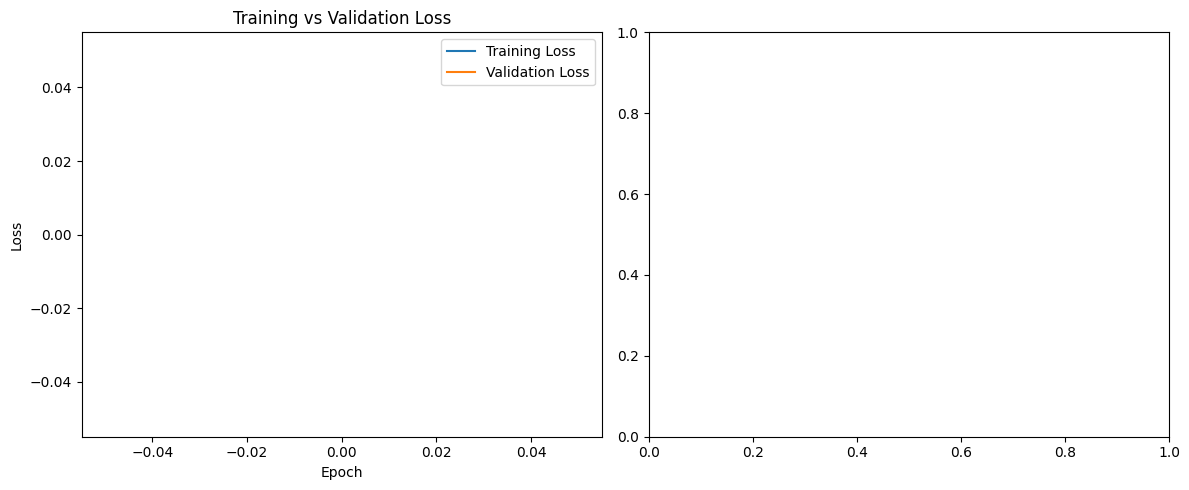

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Generating predictions...



--- Classification Report (Epoch 1) ---
              precision    recall  f1-score   support

    Negative     0.4751    0.6943    0.5642      5879
     Neutral     0.7544    0.6176    0.6792     19002
    Positive     0.7655    0.8056    0.7850     14002

    accuracy                         0.6969     38883
   macro avg     0.6650    0.7058    0.6761     38883
weighted avg     0.7162    0.6969    0.6999     38883



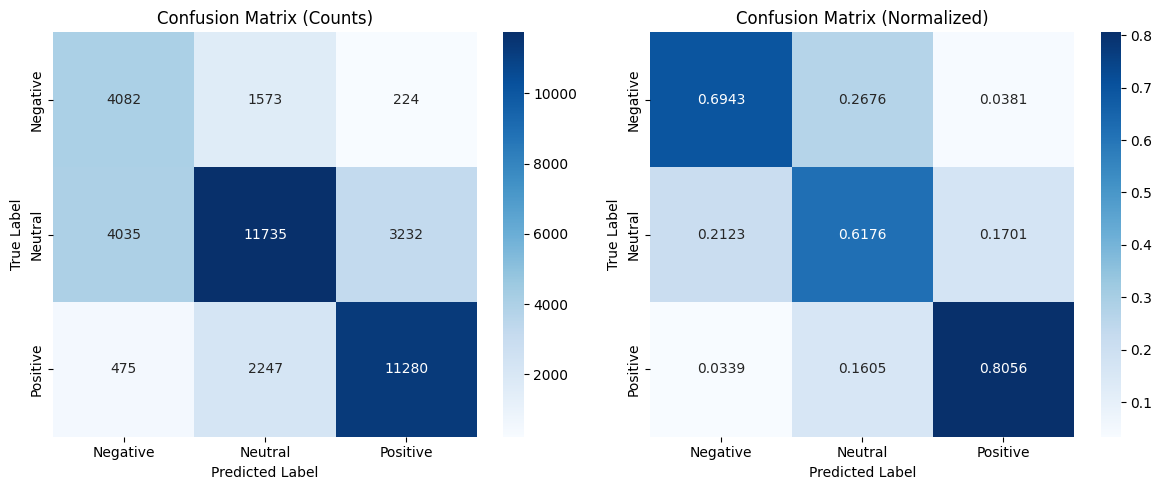

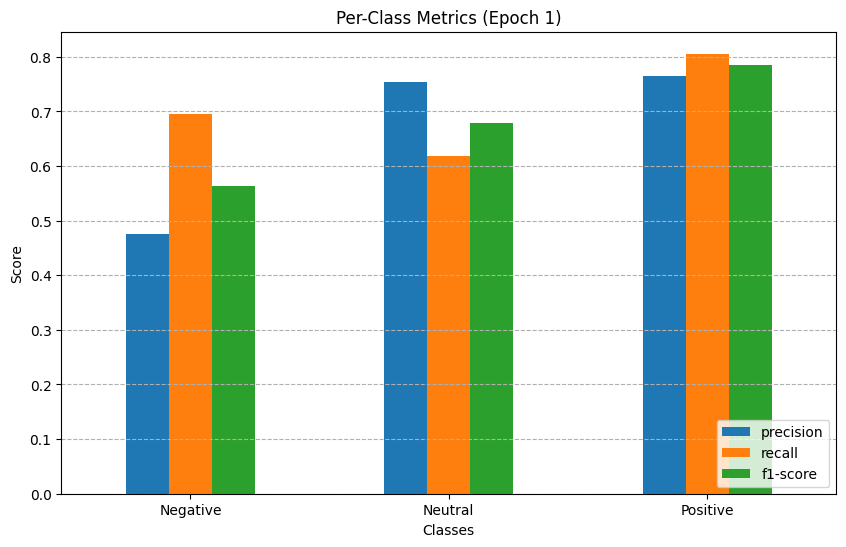


✅ Epoch 1 Model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_194k__Custom 0-4-7 [Epoch 1]


In [10]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer

# ==========================================
# 1. SETUP: DEFINE PATH TO EPOCH 1 CHECKPOINT
# ==========================================
# TODO: Check your folder. Epoch 1 is usually the checkpoint with the smallest number.
# Example: ".../checkpoint-8000" or ".../checkpoint-8250"
EPOCH_1_PATH = "/content/drive/MyDrive/THESIS 47/Saved Datasets/checkpoint-9721"

print(f"🔄 Attempting to load EPOCH 1 from: {EPOCH_1_PATH}")

# ==========================================
# 2. LOAD WEIGHTS MANUALLY
# ==========================================
# Re-initialize the architecture (Empty shell)
model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# Check for weight file
safe_path = os.path.join(EPOCH_1_PATH, "model.safetensors")
bin_path = os.path.join(EPOCH_1_PATH, "pytorch_model.bin")

if os.path.exists(safe_path):
    from safetensors.torch import load_file
    state_dict = load_file(safe_path)
    print("✅ Found and loaded model.safetensors")
elif os.path.exists(bin_path):
    state_dict = torch.load(bin_path, map_location=torch.device('cpu'))
    print("✅ Found and loaded pytorch_model.bin")
else:
    raise FileNotFoundError(f"❌ Could not find model file in {EPOCH_1_PATH}. Check the path!")

# Load weights and update Trainer
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainer.model = model
print("✅ Epoch 1 Model loaded successfully!")

# ==========================
# 3. EVALUATE • REPORT • PLOTS • SAVE
# ==========================
print("\n--- Final Evaluation on Test Set (Epoch 1) ---")

# A. PLOT LOSS CURVES
log_history = trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss'); plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

# B. PREDICTIONS (FIXED & SAFE)
print("Generating predictions...")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK START ---
if isinstance(preds_output.predictions, tuple):
    logits = preds_output.predictions[0]  # Extract logits if it's a tuple
else:
    logits = preds_output.predictions     # Use directly if it's an array
# --- SAFETY CHECK END ---

pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# C. CLASSIFICATION REPORT (4 decimal places)
print("\n--- Classification Report (Epoch 1) ---")
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# Added 'digits=4' here to show 0.1234 format
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# D. CONFUSION MATRIX (4 decimal places)
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# E. PER-CLASS BAR CHART
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Epoch 1)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()

# F. SAVE (Marked as Epoch 1)
FINAL_MODEL_PATH = f"/content/drive/MyDrive/THESIS 47/Saved Datasets/Final_Model_3Class_194k__Custom 0-4-7 [Epoch 1]"
trainer.save_model(FINAL_MODEL_PATH)
print(f"\n✅ Epoch 1 Model saved to: {FINAL_MODEL_PATH}")